# **Goal: Recommendation System / Next Best Action**

## **Context**
We have a **random extraction** of a (real world) dataset containing **customers of a large wealth management company**.  

The data is **anonymous, mostly clean, and NOT always normalized/scaled**.  

Our objective is to **estimate investment needs** for these customers using **Data Science techniques**.

### **Why Estimate Investment Needs?**
Identifying customer needs is useful for several reasons, including:

* **Recommender Systems / Next Best Action:**  
  * Needs can serve as **key inputs** for **content-based** or **knowledge-based filtering algorithms**, that allows for personalized services.  
  * This is our **primary focus** in this notebook, i.e., "Know Your Client (KYC)".  

* **Product Targeting & Governance (Regulatory Compliance - MIFID/IDD in EU):**  
  * Regulatory standards require that **customer needs match the investment products offered**. So financial institutions must estimate customer needs.
  * This is essentially an **"institutional view"** of a recommendation system...

<br>

---

## **Dataset Overview**
The dataset, named **"Needs"**, is stored in an **Excel file called Dataset2_Needs.xls**.  
It contains several **potentially relevant features** along with two **target variables**, i.e:

* **AccumulationInvestment**  
  * Indicates a customer preference for **accumulation investing**, typically through **dollar-cost averaging** (i.e., investing small amounts at regular intervals over time, say on a monthly basis).  
  * **Binary (Boolean) response:**  
    * `1 = High propensity`.  
    * `0 = Low propensity`.

- **IncomeInvestment**  
  - Indicates a customer preference for **income investing**, typically through **lump-sum investing** (i.e., one-shot investments).  This is because anyone who aspires to obtain income from coupons and dividends must necessarily already have accumulated capital - a typical need of people who are older than their previous need.
  - **Binary (Boolean) response:**  
    - `1 = High propensity`.  
    - `0 = Low propensity`.  

    **Where do these two response variables come from?** From a **revealed preference scheme**: if the client has an advisor who is considered professionally reliable (this eliminates the possibility of conflict of interest) and has purchased a product that satisfies that need, and the client has also purchased it, we can say with good probability that the advisor has identified the need correctly and the client has that need. In other respects, the machine learning model we are building is a clone of the financial advisor.

<br>

Additionally, we have a **second dataset**, **"Products"**, containing investment products (funds, segregated accounts, unit-linked policies), along with:

* **Product Type:**  
  * `1 = Accumulation` (that is, a product that is good for those who have a high need for accumulation investments)
  * `0 = Income`  (that is, a product that is good for those who have a high need for income investments)

* **Risk Level:**  
  * A **normalized risk score** in the range **$[0,1]$**.  
  * This usually represents the normalized value in $[0, 1]$ of the **[Synthetic Risk and Reward Indicator (SRRI)](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)** of the product, an ordinal variable defined in the range ${1, 7}$ starting from continuous data.

<br>

---

## **Recommendation System Approach**
The recommendation system consists of **two key steps**:

1. **Identifying customers with high investment propensity:**  
   - Using **machine learning models**, we aim to classify customers based on **AccumulationInvestment** (`1 = High propensity`) and/or **IncomeInvestment** (`1 = High propensity`).  

2. **Recommending the most suitable product for each customer:**  
   - For each customer, we match the **most appropriate product** based on:  
     - **Investment need** (Accumulation or Income).  
     - **Risk compatibility** (matching product risk level with the customer profile).  
   - This **personalized recommendation** represents the **Next Best Action** for each client.

<br>


<br>

Let's start with data ingestion.

<br>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load each sheet into separate DataFrames
# Define the file path in Google Drive
file_path = '/content/drive/MyDrive/PoliMI/Dataset2_Needs.xls'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# **Data Exploration**

As for the last business case: I keep it minimalist, for the benefit of brevity, to be able to get to the heart of the problem. But you could/can spend tons of time here in order to **understand the problem and the dataset**.

Let's display our variables to better understand the data structure and characteristics of the dataset.

<br>

In [ ]:
# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components


<br>

We drop ID column as it's not needed for analysis.

<br>

In [ ]:
# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

<br>

Create a formatted table to summarize the dataset (you can expand the number of statistics you look at).


<br>

In [ ]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


<br>

## Data Transformation and Exploratory Analysis

### 1. Initial setup
* Import required libraries (seaborn, matplotlib, etc).
* Create utility function for histogram plotting.

### 2. Target variables analysis: are they imbalanced?
* Visualize distribution of Income Investment needs.
* Visualize distribution of Accumulation Investment needs.
* Assess class balance for both target variables.

### 3. Wealth variable transformation analysis: is it too fat-tailed?
Display the fat-tailed shape of the Wealth variable, and effect of a couple of reasonable transformations on the Wealth variable. We examine three versions of the Wealth variable:
* Original Wealth distribution.
* Log transformation.
* Power transformation (0.1 power).
* Evaluate which transformation better normalizes the distribution, identifying the most appropriate transformation for leptokurtic, skewed wealth data.

### 4. Some feature engineering and scaling
* Apply log transformation to Wealth and Income.
* Normalize selected variables using MinMaxScaler.
* Create a standardized feature set for modeling.

### 5. Multivariate analysis
* Generate a correlation matrix heatmap for all numeric variables.
* Create pairwise relationships visualization.
* Examine relationships between transformed variables and target variables.

<br>


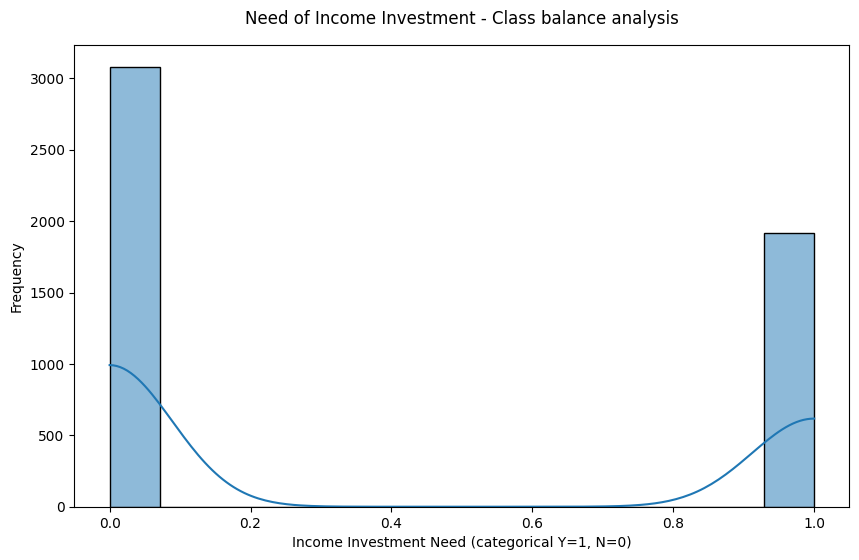

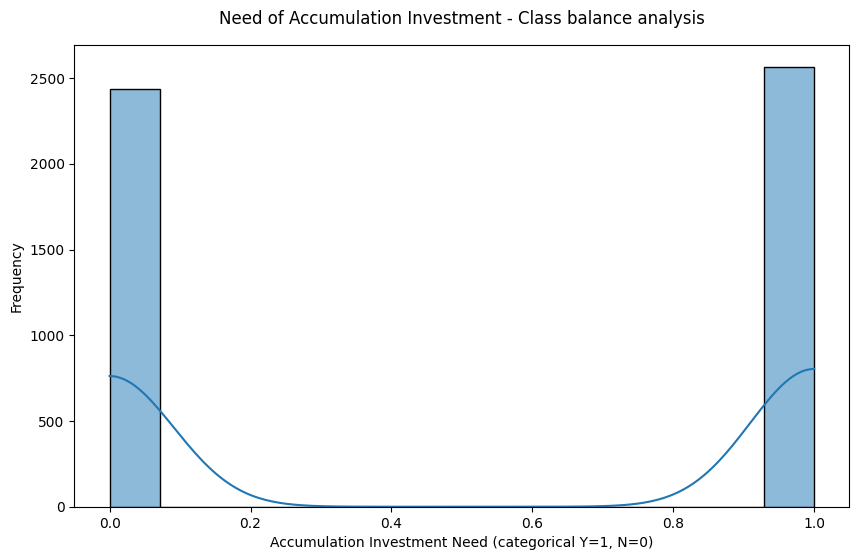

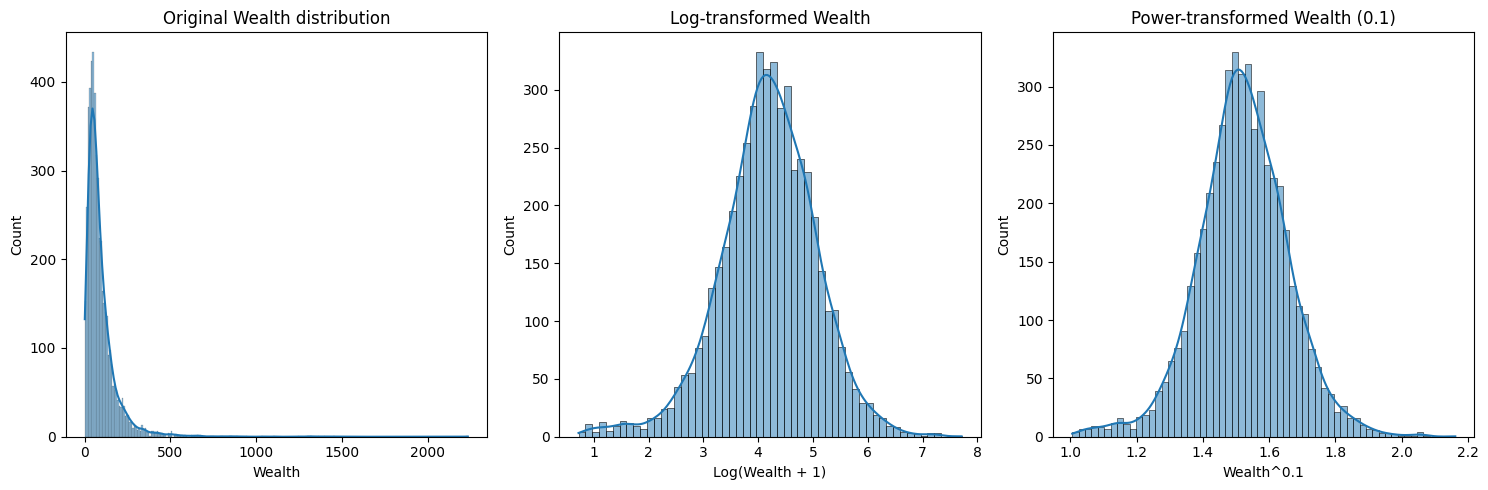

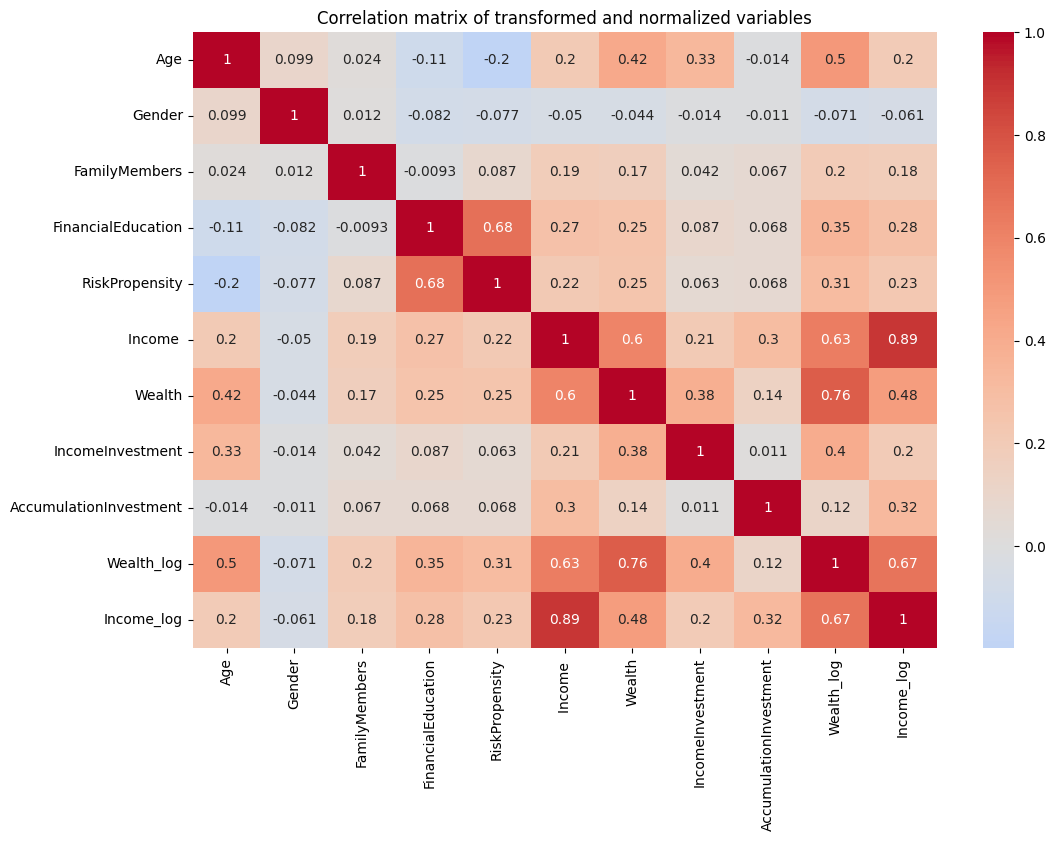

<Figure size 1500x1500 with 0 Axes>

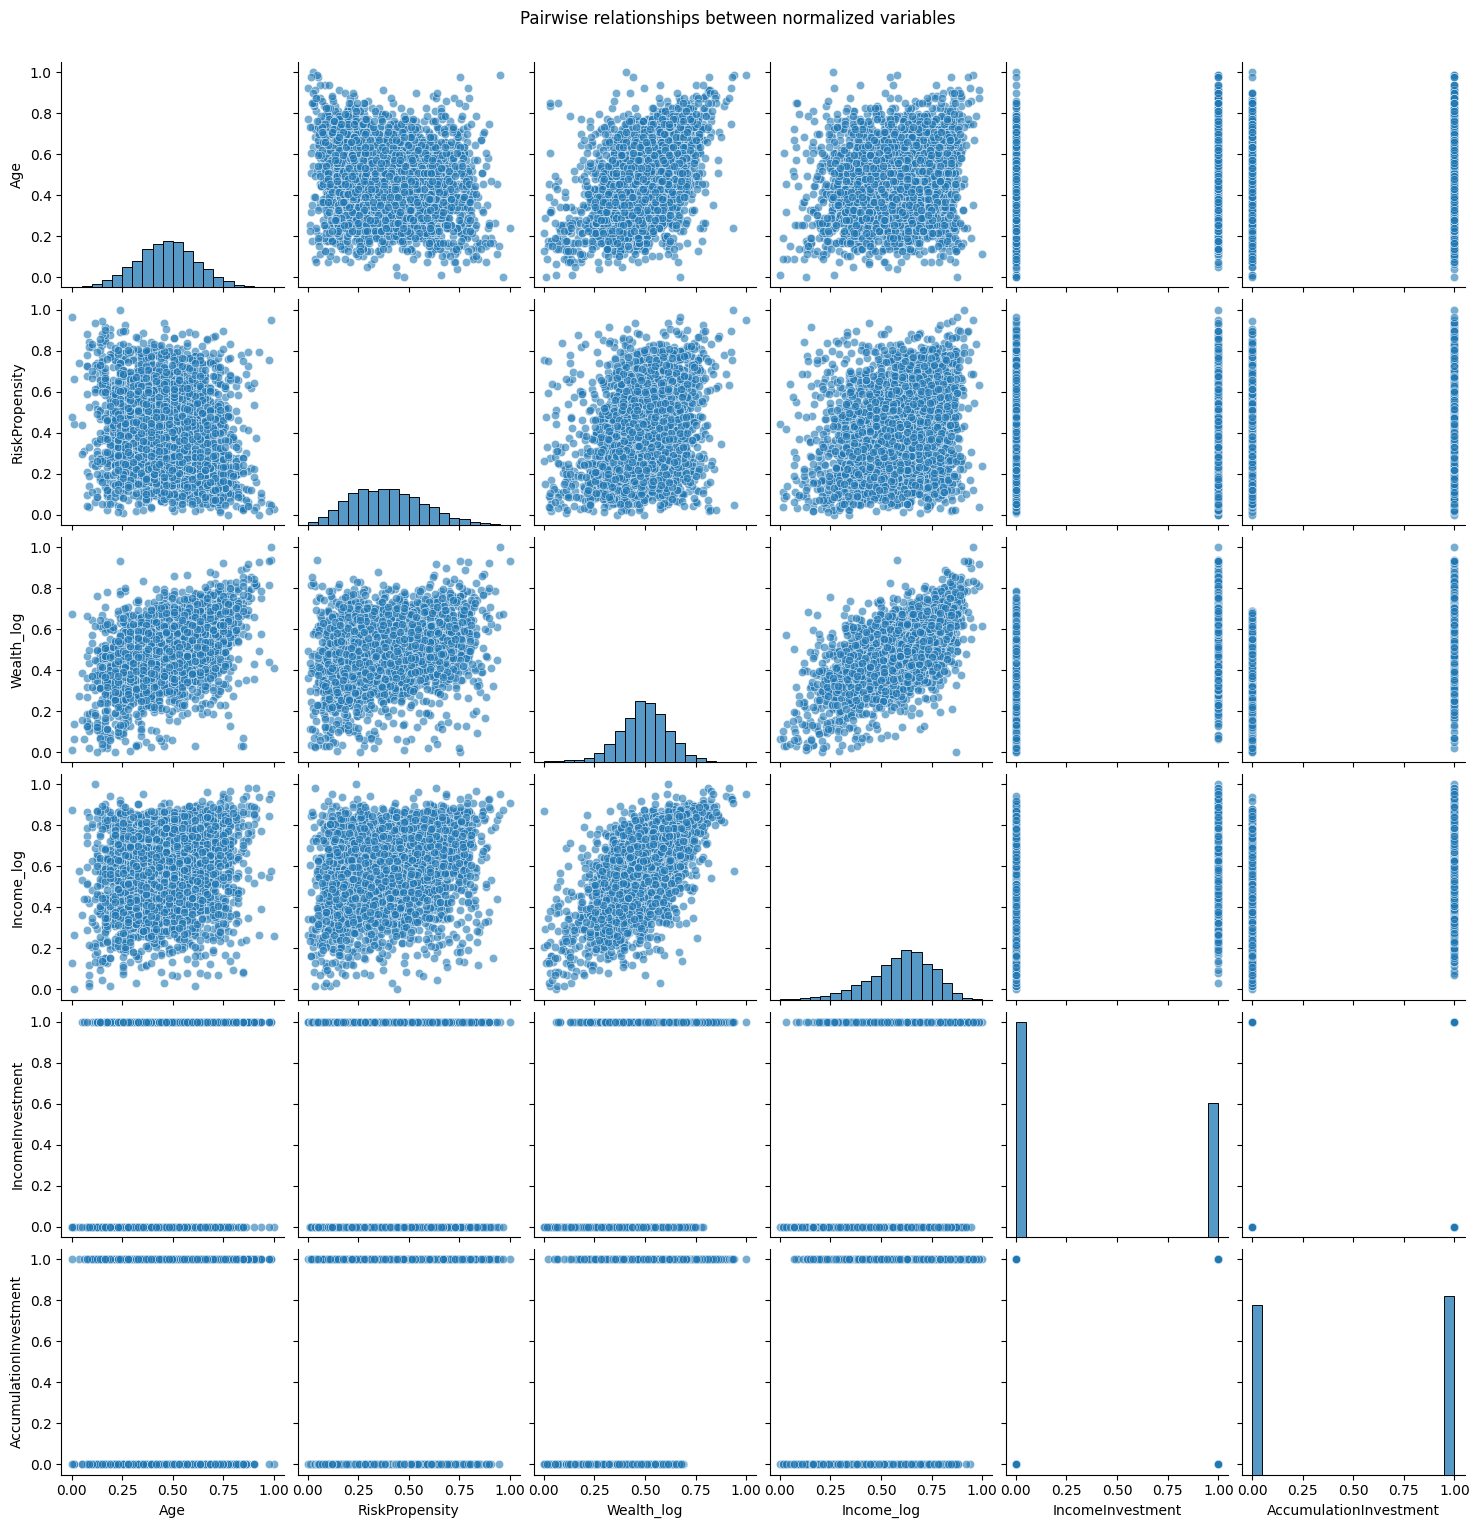

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Create df with all transformations and normalizations
transformed_df = needs_df.copy()

# Create a function for histogram plotting
def plot_histogram(data, title, xlabel, ylabel="Frequency"):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True)
    plt.title(title, pad=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# Plot class balance histograms
plot_histogram(needs_df.IncomeInvestment,
              'Need of Income Investment - Class balance analysis',
              'Income Investment Need (categorical Y=1, N=0)')

plot_histogram(needs_df.AccumulationInvestment,
              'Need of Accumulation Investment - Class balance analysis',
              'Accumulation Investment Need (categorical Y=1, N=0)')

# Wealth transformation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
sns.histplot(needs_df.Wealth, kde=True, ax=ax1)
ax1.set_title('Original Wealth distribution')
ax1.set_xlabel('Wealth')

# Log transformation
sns.histplot(np.log1p(needs_df.Wealth), kde=True, ax=ax2)
ax2.set_title('Log-transformed Wealth')
ax2.set_xlabel('Log(Wealth + 1)')

# Power transformation
sns.histplot(np.power(needs_df.Wealth, 0.1), kde=True, ax=ax3)
ax3.set_title('Power-transformed Wealth (0.1)')
ax3.set_xlabel('Wealth^0.1')

plt.tight_layout()
plt.show()

# Apply log transformations
transformed_df['Wealth_log'] = np.log1p(transformed_df['Wealth'])
transformed_df['Income_log'] = np.log1p(transformed_df['Income '])

# Apply MinMaxScaler to numerical variables
scaler = MinMaxScaler()
vars_to_normalize = ['Age', 'RiskPropensity', 'Wealth_log', 'Income_log']
transformed_df[vars_to_normalize] = scaler.fit_transform(transformed_df[vars_to_normalize])

# Get all numeric columns including transformed ones (and not transformed, for comparison)
numeric_cols = transformed_df.select_dtypes(include=['float64', 'int64']).columns

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transformed_df[numeric_cols].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation matrix of transformed and normalized variables')
plt.show()

# Create enhanced pairplot
vars_to_plot = vars_to_normalize + ['IncomeInvestment', 'AccumulationInvestment']
plt.figure(figsize=(15, 15))
sns.pairplot(transformed_df[vars_to_plot],
             diag_kind='hist',
             plot_kws={'alpha': 0.6},
             diag_kws={'bins': 20})
plt.suptitle('Pairwise relationships between normalized variables', y=1.02)
plt.show()

# **HINTs**:

* Other **EDA ideas**:

    * You could add box plots to identify **outliers**.
    * You could add Q-Q plots to check for **normality**.
    * You might include [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html) for categorical variables - to observe and **compare the distribution of numeric data between multiple groups** (e.g., Gender, grouping by Financial Education, or whatever you think might make sense as a grouping variable): peaks, valleys, and tails of each group’s density curve can be compared to see where groups are similar or different.
    * You can add distribution plots, **comparing different demographic groups**.
    * For some pairs of features you can plot joint and marginal distribution to understand **dependence** (maybe a candidate response variable and a candidate explanatory variable) using a [joint plot, aka scatter histogram plot](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot).
    * ...and more.

<br>

## Baseline models with feature engineering analysis

This section implements a comprehensive baseline modeling pipeline with **two different feature sets** and **two baseline models**.

### Modeling approach: Binary Classification for investment needs
This analysis implements two **separate binary classifiers for each investment need**, rather than a **single multi-output classifier**, i.e., we have separate model for:
* Income Investment needs prediction.
* Accumulation Investment needs prediction.

While we could model this as a single classification problem with four possible outcomes ${(1,1), (0,1), (1,0), (0,0)}$, using separate binary classifiers offers several advantages:
* Simpler model interpretation.
* Independent feature importance analysis for each need.
* Flexibility to use different model architectures for each need.
* Greater statistical robustness due to reduced model complexity.
* More reliable performance with limited training data
* Easier model maintenance and updating (as the model is relatively simpler).

### Feature engineering and data preparation
* Creation of *base* feature set and an *engineered* feature set, both using log-transformed Wealth and Income - we properly transform and normalize all features using MinMaxScaler.

* The *engineered feature set* includes a domain-knowledge-based variable, i.e.,the **Income/Wealth ratio feature**. The underlying idea is:
    * Accumulation investment products are mainly (though not only) intended for relatively young people, say workers, who have more income than accumulated wealth.
    * "Income" investment products are mostly intended for a public that has already accumulated a wealth, and is often older (often they are retired);
    * since the response variables derive from the behavior of financial advisors who hopefully follow this practice, an interesting variable is the ratio income / wealth ratio.

* **Stratified train-test split** for balanced evaluation, as we divide data in:
    * **Train/crossvalidation** sample - we we will use **[k-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))**, with $k = 5$ (typical values for $k$ are $3÷10$).
    * **Test sample** - it is the hold-out set, i.e., truly out-of-sample.
    * To give you an idea, the proportion train/crossvalidation-test might be 70%-30%, or 80%-20%, even 95%-5% if the dataset is really large. In fact, according to common practice, it is enough that the hold-out set is sufficiently large and representative in absolute terms.

### Model Implementation
Two baseline models are tested:
* **[Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine)**.
* **[Gaussian Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)**.

Each model is evaluated on both feature sets to assess the impact of feature engineering, i.e., how good is the Income/Wealth ratio feature.

### Recap of evaluation framework
* **K-fold cross-validation (k=5) on training data**.
* Final evaluation on **hold-out test set**.
* Comprehensive metrics - [this is a good recap](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall):
  * Accuracy.
  * Precision.
  * Recall.
  * F1-score.
* Metrics are computed for each fold, thus reporting mean and standard deviation for all metrics in cross-validation.
* Results displayed with both:
    * cross-validation statistics and test set performance.
    * *base* and *engineerd* dataset.

<br>


In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Step 1: Feature engineering and transformation function
def prepare_features(df):
    X = df.copy()

    # Log transformation for Wealth and Income
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])

    # Create Income/Wealth ratio
    X['Income_Wealth_Ratio'] = X['Income '].div(X['Wealth'].replace(0, np.nan)).fillna(X['Income '].max())
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'])

    # Select features for modeling
    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                    'RiskPropensity', 'Wealth_log', 'Income_log']

    features_engineered = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                          'RiskPropensity', 'Income_Wealth_Ratio_log']

    # Normalize all features
    scaler = MinMaxScaler()
    X_base = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    return X_base, X_engineered

# Step 2: Data split function
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Step 3: Model training and evaluation function
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }

# Step 4: Display results function
def display_results_table(results_dict, model_name, feature_type):
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [
            results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    df = pd.DataFrame(cv_data)
    df = df.round(3)

    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

# Step 5: Run full analysis
# Prepare features
X_base, X_engineered = prepare_features(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

# Define models
models = {
    'SVM': SVC(),
    'NaiveBayes': GaussianNB()
}

# Actually run analysis and display results
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    for model_name, model in models.items():
        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        display_results_table(results_base, model_name, "Base Features")

        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
        display_results_table(results_eng, model_name, "Engineered Features")



Target Variable: Income Investment

SVM - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.771  | 0.015  |  0.747   |
| 1 | Precision |  0.816  | 0.011  |  0.796   |
| 2 |  Recall   |  0.521  |  0.04  |  0.458   |
| 3 |    F1     |  0.635  | 0.027  |  0.582   |
+---+-----------+---------+--------+----------+

SVM - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.724  | 0.018  |  0.707   |
| 1 | Precision |  0.771  | 0.035  |  0.733   |
| 2 |  Recall   |  0.402  | 0.026  |  0.372   |
| 3 |    F1     |  0.528  | 0.024  |  0.494   |
+---+-----------+---------+--------+----------+

NaiveBayes - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+-------

<br>

### Comments on this first try:

* Base features consistently outperform engineered features across both models. This suggests that keeping Wealth and Income as separate features provides better predictive power than their ratio. But maybe we could refine the feature engineering process...
* Model Performance: SVM shows superior performance overall, and results are not bad for baseline models (note: there is not any tuning).
* Model Stability: CV standard deviations are relatively small (mostly < 0.03), and test set performance aligns well with CV results, indicating good generalization.

<br>



# HINT:
* Try to **engineer your features** using some financial knowledge (maybe you can find a rationale for the number of family members, the gender, maybe it's linked to the client's life-cycle or whatever).
* Try one or more **other baseline models** - memento: baseline models are relatively simple, so K-NN, SVM, Decision Trees, Logistic Regression, etc. may work well. BTW, simple does not mean that they do not work well: sometimes they generalize well and do not overfit, and often they are easier to interpret (think of logistic regression, which has parameters, the coefficients, directly interpretable).

<br>

## Moving to higher complexity models

Let's go a step further and use higher complexity models: they can potentially provide better results (because they better capture nonlinearities, complex interactions, basically dealing with feature engineering), with the risk of overfitting and not really learning to generalize.

### Ensemble learning context
**[Bagging and boosting approaches](https://www.kaggle.com/code/prashant111/bagging-vs-boosting)**, based on the brilliant idea of **[ensemble model](https://www.researchgate.net/figure/General-idea-of-ensemble-learning_fig2_333988996)**, are particularly effective for financial services datasets, which typically feature:
* Mixed categorical and numerical features.
* Complex non-linear relationships.
* Some noise in the data.
* Imbalanced class distributions.


## XGBoost

**XGBoost, as an advanced gradient boosting framework**, is an implementation, an open-source software library which provides a fast and powerful regularizing gradient boosting framework. It builds on ensemble learning strengths by:
* Combining multiple weak learners into a robust model.
* Sequential error correction through gradient optimization.
* Effective handling of feature interactions.

### Our implementation
The model is evaluated using:
* Both feature sets (base and engineered).
* Same cross-validation and hold-out test framework.
* Identical metrics suite for direct comparison with baseline models.

This allows for a clear assessment of performance gains from:
1. Using a more advanced algorithm, like XGBoost.
2. Different feature engineering approaches.

Let's see what happens.

<br>

In [ ]:
import xgboost as xgb

# Updated XGBoost configuration
models = {
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    )
}

# Run the analysis
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    model = models['XGBoost']

    results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
    display_results_table(results_base, 'XGBoost', "Base Features")

    results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
    display_results_table(results_eng, 'XGBoost', "Engineered Features")



Target Variable: Income Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.786  | 0.018  |  0.759   |
| 1 | Precision |  0.778  | 0.017  |   0.76   |
| 2 |  Recall   |  0.621  | 0.031  |  0.544   |
| 3 |    F1     |  0.69   | 0.025  |  0.634   |
+---+-----------+---------+--------+----------+

XGBoost - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.717  | 0.019  |  0.699   |
| 1 | Precision |  0.666  | 0.023  |  0.646   |
| 2 |  Recall   |  0.528  | 0.033  |  0.479   |
| 3 |    F1     |  0.588  | 0.027  |   0.55   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean

Looking at our results, XGBoost performs excellently, with good F1, and a very balanced precision and recall.

The base features still consistently outperform the engineered features, suggesting we should stick with the original feature set, sorry for domain knowledge...

<br>



# Understanding how prediction comes: introducing Explainable AI (XAI)

The general idea is: examining which features contribute most to the model's predictions, i.e. explaining model results, and thus providing insights into model decision-making process.
This kind of analysis helps us understand:
* Which variables drive predictions.
* Validation of feature engineering choices.

Let's explore **Feature Importance** from XGBoost to understand which variables are driving these good predictions. Feature importance is a core technique in **Explainable AI (XAI)**, which aims to make machine learning models **transparent and accountable**.  Understanding **which features matter most** improves **trust, debugging, compliance (e.g., MIFID/IDD in Fintech/Finance), and model performance**.

Common XAI methods include **SHAP values, Permutation Importance, and Tree-based feature importance**.

**Feature Importance** quantifies the **impact** of each input feature on a model's predictions.  


Note: In what follows we violate the DRY (Don't Repeat Yourself) principle in coding, rewriting the function `train_evaluate_model(.)`, adding the feature importance analysis capability by returning the trained model (this second version adds 'model' to the returned dictionary.).

## Feature Importance analysis

The following implementation includes different steps.

### Enhanced model evaluation
* Updated `train_evaluate_model` function now returns the trained model.
* Maintains all previous metrics and cross-validation capabilities.
* Enables subsequent feature importance analysis.

### Feature Importance visualization
* New `plot_feature_importance` function creates clear visual representations.
* Uses XGBoost's built-in feature importance scores, i.e., XGBoost directly calculates importance through its `feature_importances_` attribute.
* Displays results as sorted bar plots for direct interpretation.

<br>



Feature Importance for Income Investment


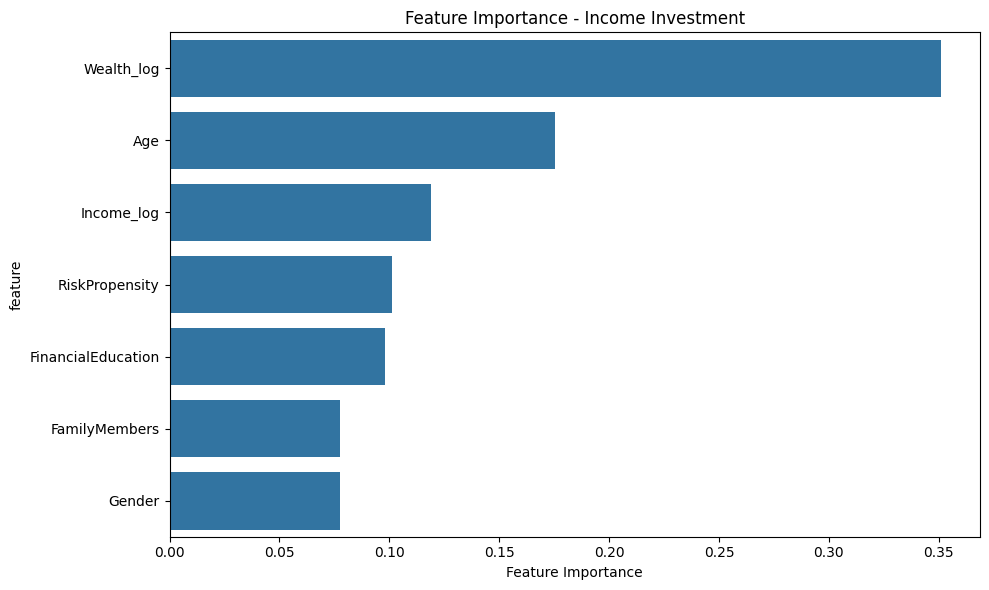


Feature Importance for Accumulation Investment


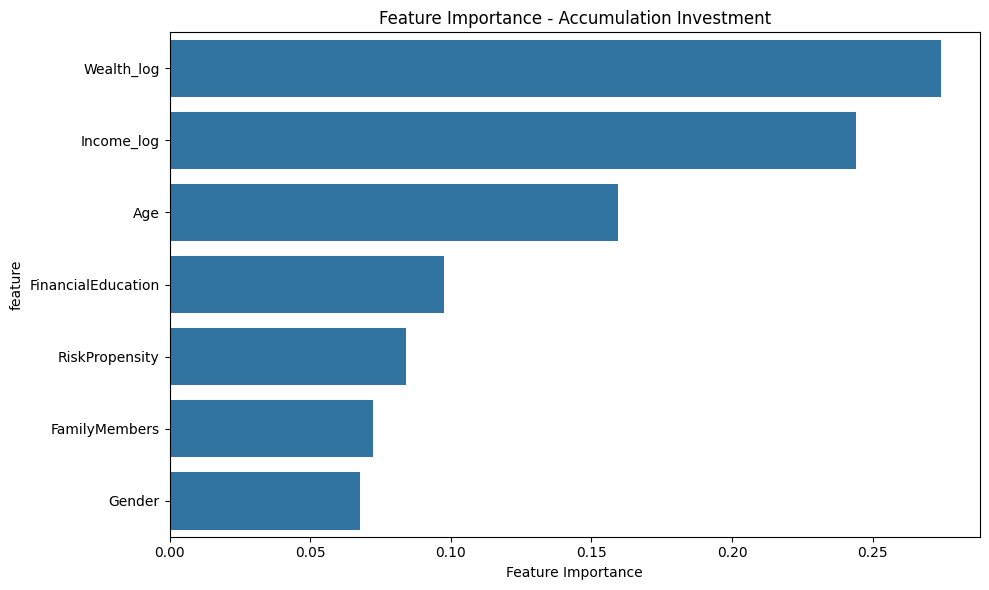

In [ ]:
# Rewrite the function, returning the trained model, too
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        },
        'model': model
    }


# Feature importance function: capture the trained models during our initial
# training phase and then use them for feature importance analysis
def plot_feature_importance(model, feature_names, title):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

# Define models
models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# Run analysis and plot feature importance
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nFeature Importance for {target_name}")
    print("=" * 50)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    results = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, models['XGBoost'])

    plot_feature_importance(results['model'], X_base.columns, f'Feature Importance - {target_name}')


## SHAP Values analysis

Shapley values, derived from Game Theory, provide a unified measure of feature importance that shows both the magnitude and direction of each feature's impact on model predictions. Unlike traditional feature importance, SHAP values reveal how each feature contributes positively or negatively to individual predictions. It's state-of-the-art XAI.

### Local and global interpretability: SHAP can do both
* **Local Analysis**: SHAP values explain individual predictions, showing how each feature contributed to a specific outcome.
* **Global Analysis**: Aggregating SHAP values across all predictions provides overall feature importance and interaction patterns.

### Implementation details
* Uses TreeExplainer, specifically designed for tree-based models like XGBoost
* Generates two complementary visualizations:
  * Bar plot of aggregated SHAP values, showing overall feature importance (global interpretation).
  * Summary plot showing feature impact distributions across all predictions  (combining local and global insights).
* Separate analysis for both investment needs using hold-out test data

This analysis should provides deeper insights into:
* Feature contribution magnitude.
* Direction of feature impacts
* Feature value **ranges** that most influence predictions
* Individual and population-level patterns

<br>




SHAP Analysis for Income Investment


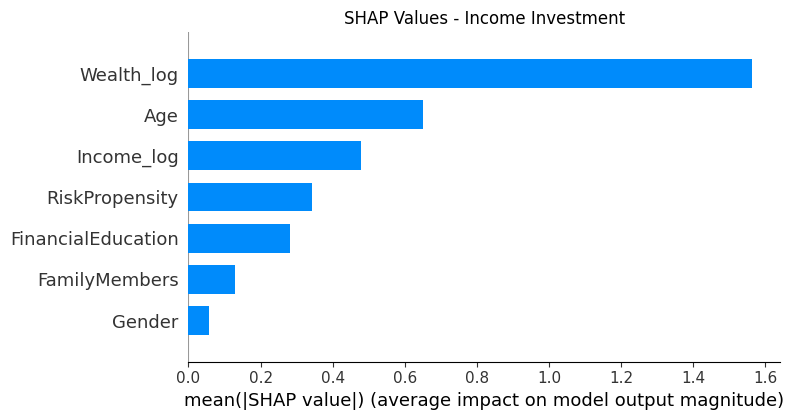

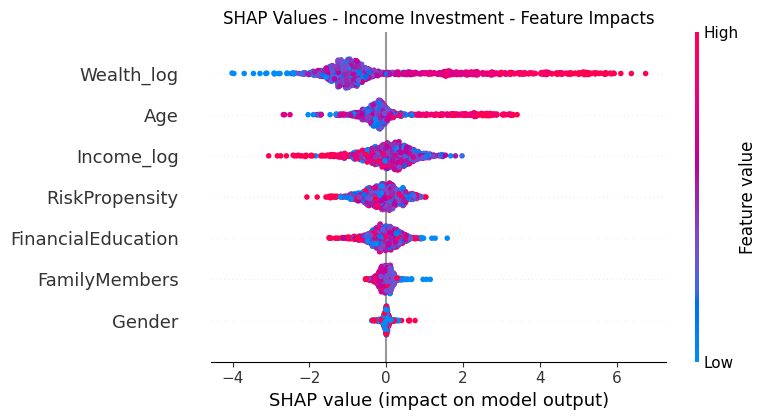


SHAP Analysis for Accumulation Investment


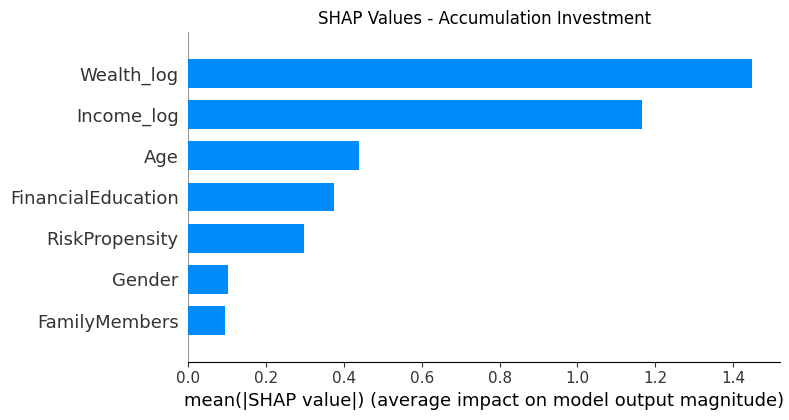

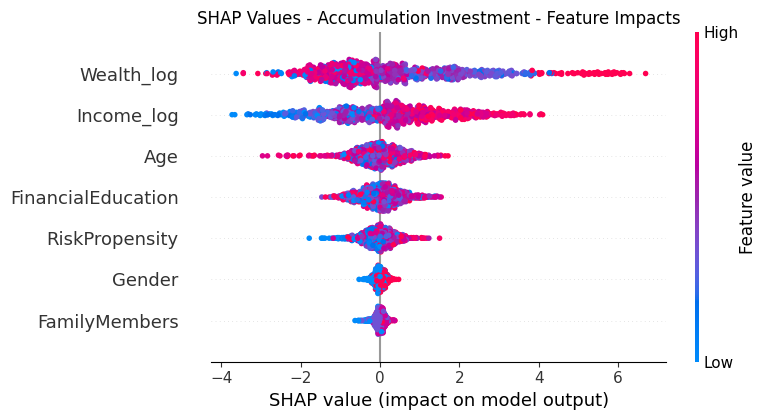

In [ ]:
import shap

def plot_shap_values(model, X, title):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"{title} - Feature Impacts")
    plt.tight_layout()
    plt.show()

# Calculate and plot SHAP values for both targets
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nSHAP Analysis for {target_name}")
    print("=" * 50)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    results = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, models['XGBoost'])

    plot_shap_values(results['model'], X_base_test, f'SHAP Values - {target_name}')


<br>

The results of Feature Importance analysis and SHAP seem overall quite comparable.

The alignment between feature importance and SHAP values reinforces our confidence in the model's interpretability. This consistency between different explanation methods validates our understanding of how features influence the predictions. It's particularly valuable to see both approaches highlighting similar key features, which strengthens our trust in the model's decision.


<br>

# **HINTs**

### **From the XAI side**

* Analyze the results carefully. And, for **local interpretability**, implement **individual SHAP prediction explanations** using:

```python
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
```
    This will show how features contribute to specific individual predictions.

* **Additional interpretability methods** - Several other powerful methods can complement our current analysis:

1. LIME (Local Interpretable Model-agnostic Explanations)
   - Library: [`lime`](https://lime-ml.readthedocs.io/en/latest/).
   - Explains individual predictions through local approximation.

2. Permutation Importance
   - Library: [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html).
   - Measures feature importance through performance impact.

3. Partial Dependence Plots (PDP)
   - Library: [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html) or [`pdpbox`](https://pdpbox.readthedocs.io/en/latest/).
   - Visualizes feature-target relationships

4. ICE (Individual Conditional Expectation) Plots
   - Library: [`pdpbox`](https://pdpbox.readthedocs.io/en/latest/).
   - Shows detailed feature impact on individual predictions.

### **From the modeling side**

* **Try other Boosting/Bagging models***
For example, **Random Forest**, a workhorse of Machine Learning that almost never denies decent results. Or use your imagination and curiosity...

* **Rank the models using rules**
Give yourself some rules to establish which models are better:
    * typically identify a **primary rule, or Optimizaion metric**, (e.g. "I want to optimize Recall") and **secondary rules, or Sufficiency Metrics**, very often more than one, for example "I want Precision higher than the minimum threshold of decency = X", "I want the training time to be a maximum of T seconds", etc.
    * **The choice of the primary rule, depends on the business context**. To understand it, **look at the Confusion Matrix** and think about what Accuracy, Precision, Recall, F1 are... but first read the following section.


 <br>

 ---

 <br>

# **Important digression: choosing the right validation metric: what really matters?**  

Which metric should we prioritize?  Each metric captures a different aspect of performance, and understanding their meaning is crucial:  

* **Accuracy**:
  * Measures **overall correctness**—the proportion of correctly classified customers.  
  * ⚠️ **Does not distinguish between errors** and performs **poorly on imbalanced data**.

* **Recall**:   
  * **Answers the question: "Out of all customers with Need X, how many did the model correctly identify?"**  
  * Useful when **missing true positives is costly** (e.g., detecting high-value prospects).

- **Precision**:  
  - **Answers the question: "Out of all customers predicted to have Need X, how many actually have it?"**  
  - Important when **false positives must be minimized** (e.g., avoiding irrelevant recommendations).

- **F1 Score**:  
  - **Harmonic mean of Precision and Recall**, balancing the trade-off between them.  
  - Ideal when both **false positives and false negatives matter**, or you are undecided...

Beyond these metrics:  
- **Lift**: Measures how much better the model is compared to random selection, useful in marketing and targeting.  
- **AUC-ROC / AUC-PR**: Assess **ranking performance** rather than just classification, critical in high-class imbalance settings.  

**Remember: No single metric is universally best.** The right choice depends on **business/practical objectives**. Think before choosing—metrics shape model behavior.


<br>

<br>

Now let's move to another class of models, a **Multilayer Perceptron (MLP) Neural Network (NN)**, a family of powerful and flexible models - and therefore at **risk of overfitting**.


## Multi-Layer Perceptron implementation

### NN architecture rationale
* **Decreasing Layer Sizes** (64 → 32 → 16 → 1): Creates a bottleneck architecture that forces the NN to learn increasingly compact representations (maybe reducing the risk of overfitting).
* **Batch Normalization**: Makes training of NN faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. [Batch Normalization](https://arxiv.org/abs/1502.03167) addresses internal covariate shift, particularly important with our mixed-scale financial features.
* **Dropout=0.2**: [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) is a light regularization that maintains most information while preventing co-adaptation. Basically, dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.
* **ReLU**: Provides non-linearity without gradient vanishing issues common in financial data modeling.
* **Sigmoid Output**: Transforms final layer output into probability scores for binary classification.

### Training configuration and reasoning
* **Binary Cross Entropy Loss**: Natural choice for binary classification with probabilistic interpretation
* **Adam Optimizer (lr=0.001)**: Adaptive learning rates help handle different feature scales.
* **Batch size=32**: Good balance between computational efficiency and gradient estimation.
* **100 epochs**: Sufficient iterations for convergence with validation monitoring every 10 epochs.

### Data handling
* Custom PyTorch Dataset class for efficient data loading.
* Separate training and evaluation pipelines.
* Comprehensive metrics evaluation (accuracy, precision, recall, F1), comparable to previous models.

<br>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Accuracy: {accuracy_score(val_true, val_preds):.4f}')

# Use the same data split as before
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model, criterion, optimizer
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_model(model, train_loader, test_loader, criterion, optimizer)



Training Neural Network for Income Investment
Epoch 10, Train Loss: 0.5269, Val Loss: 0.5433, Val Accuracy: 0.7500
Epoch 20, Train Loss: 0.5050, Val Loss: 0.5368, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.5148, Val Loss: 0.5411, Val Accuracy: 0.7610
Epoch 40, Train Loss: 0.5069, Val Loss: 0.5305, Val Accuracy: 0.7560
Epoch 50, Train Loss: 0.5106, Val Loss: 0.5345, Val Accuracy: 0.7670
Epoch 60, Train Loss: 0.5073, Val Loss: 0.5351, Val Accuracy: 0.7550
Epoch 70, Train Loss: 0.5001, Val Loss: 0.5306, Val Accuracy: 0.7650
Epoch 80, Train Loss: 0.4980, Val Loss: 0.5423, Val Accuracy: 0.7530
Epoch 90, Train Loss: 0.5039, Val Loss: 0.5303, Val Accuracy: 0.7660
Epoch 100, Train Loss: 0.4993, Val Loss: 0.5314, Val Accuracy: 0.7600

Training Neural Network for Accumulation Investment
Epoch 10, Train Loss: 0.5696, Val Loss: 0.5583, Val Accuracy: 0.7060
Epoch 20, Train Loss: 0.5361, Val Loss: 0.5013, Val Accuracy: 0.7690
Epoch 30, Train Loss: 0.5203, Val Loss: 0.4924, Val Accuracy: 0.7760
Ep

In [ ]:
# Model evaluation
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())

    return {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

# Evaluate and display results
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nResults for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get metrics
    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    # Display results
    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)




Results for Income Investment

Neural Network Metrics:
           Training   Test
accuracy      0.549  0.532
precision     0.420  0.405
recall        0.462  0.469
f1            0.440  0.435

Results for Accumulation Investment

Neural Network Metrics:
           Training   Test
accuracy      0.812  0.794
precision     0.886  0.843
recall        0.728  0.735
f1            0.799  0.785


<br>

Good results, certainly not exceptional.

Let's take another small step forward and introduce an enhanced version that maintains the core architecture while adding more sophisticated training dynamics and monitoring capabilities.

## Enhanced MLP implementation with Learning Curves

### Key Enhancements
* **Learning rate scheduler**: Implements **ReduceLROnPlateau** for **adaptive learning rate adjustment** - it's a smart technique, look at [this paper](https://arxiv.org/abs/1506.01186) and [this other one](https://arxiv.org/abs/1803.09820):
  * Reduces learning rate by 50% after 10 epochs without improvement.
  * Helps overcome plateaus and fine-tune learning in later stages.

* **Performance monitoring**:
  * Tracks training and validation losses across epochs.
  * Monitors validation accuracy progression.
  * Stores metrics for visualization.

* **Visualization capabilities**:
  * Real-time learning curves display.
  * Side-by-side loss and accuracy plots.
  * Visual assessment of model convergence and potential overfitting. Overfitting occurs when a model **performs well on training data but poorly on validation data**. In learning curves, this appears as:  
    * **Training loss decreasing steadily**.
    * **validation loss stops improving (plateaus) or increases** after a certain epoch.
    * A **large gap** between training and validation performance indicates overfitting, suggesting the need for **regularization, more data, or early stopping**.

The idea is you should:
- Experiment better convergence through **adaptive learning rates**.
- Get visual insights into training dynamics.
- Be able to identify overfitting/underfitting.
- Overall: More informed model evaluation.

<br>

In [ ]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Training Neural Network for Income Investment
Epoch 10, Train Loss: 0.5309, Val Loss: 0.5410, Val Accuracy: 0.7540
Epoch 20, Train Loss: 0.5151, Val Loss: 0.5374, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.5125, Val Loss: 0.5445, Val Accuracy: 0.7480
Epoch 40, Train Loss: 0.5144, Val Loss: 0.5332, Val Accuracy: 0.7580
Epoch 50, Train Loss: 0.5100, Val Loss: 0.5367, Val Accuracy: 0.7560
Epoch 60, Train Loss: 0.5084, Val Loss: 0.5350, Val Accuracy: 0.7600
Epoch 70, Train Loss: 0.5039, Val Loss: 0.5301, Val Accuracy: 0.7630
Epoch 80, Train Loss: 0.5009, Val Loss: 0.5340, Val Accuracy: 0.7640
Epoch 90, Train Loss: 0.5048, Val Loss: 0.5356, Val Accuracy: 0.7630
Epoch 100, Train Loss: 0.5056, Val Loss: 0.5318, Val Accuracy: 0.7620


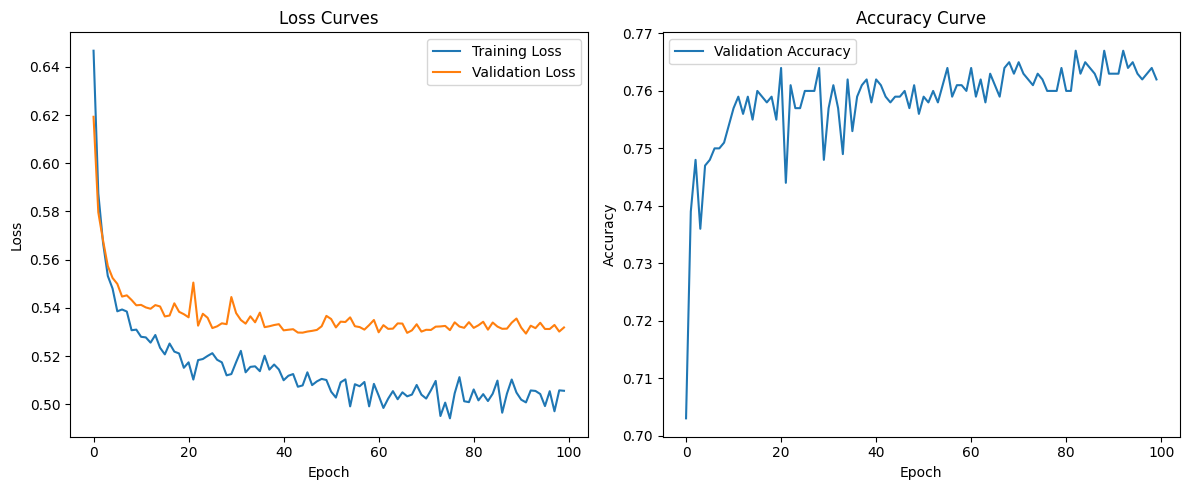


Results for Income Investment

Neural Network Metrics:
           Training   Test
accuracy      0.806  0.762
precision     0.846  0.794
recall        0.603  0.513
f1            0.704  0.623

Training Neural Network for Accumulation Investment
Epoch 10, Train Loss: 0.5598, Val Loss: 0.5285, Val Accuracy: 0.7420
Epoch 20, Train Loss: 0.5329, Val Loss: 0.5011, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.5186, Val Loss: 0.4945, Val Accuracy: 0.7750
Epoch 40, Train Loss: 0.5231, Val Loss: 0.4932, Val Accuracy: 0.7590
Epoch 50, Train Loss: 0.5175, Val Loss: 0.4805, Val Accuracy: 0.7680
Epoch 60, Train Loss: 0.5207, Val Loss: 0.4774, Val Accuracy: 0.7760
Epoch 70, Train Loss: 0.4985, Val Loss: 0.4786, Val Accuracy: 0.7870
Epoch 80, Train Loss: 0.5029, Val Loss: 0.4709, Val Accuracy: 0.7830
Epoch 90, Train Loss: 0.4950, Val Loss: 0.4744, Val Accuracy: 0.7880
Epoch 100, Train Loss: 0.4981, Val Loss: 0.4689, Val Accuracy: 0.7820


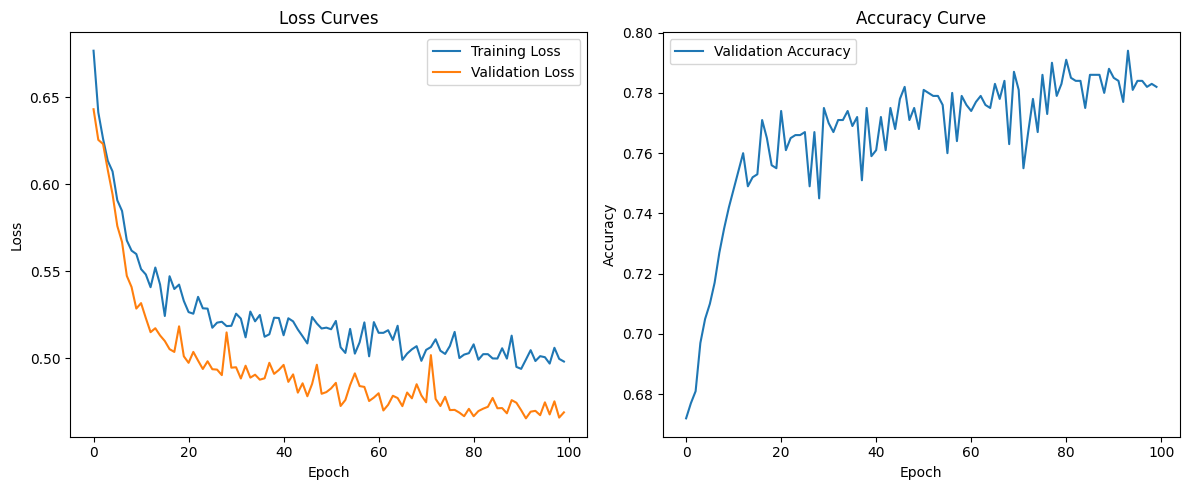


Results for Accumulation Investment

Neural Network Metrics:
           Training   Test
accuracy      0.816  0.782
precision     0.911  0.849
recall        0.711  0.700
f1            0.798  0.767


In [ ]:
# Training and evaluation for both targets
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model, criterion, optimizer
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

    # Display final metrics
    print(f"\nResults for {target_name}")
    print("=" * 50)

    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)


<br>

Short comment: these are rather strong results! The batch normalization and learning rate scheduler have improved the model's performance significantly. These results are competitive with XGBoost (particularly for Accumulation Investment prediction).

<br>

As you can see, thinking about the **NN architechture**, and **hyperparameter tuning** - broadly speaking, all aspects of the network architecture that can be changed are considered hyperparameters - can provide **significant improvements**.

<br>

# Personalized investment recommendations

## Overview

In the end, in this section, we'll implement a personalized recommendation system for investment products based on client characteristics and risk profiles. The recommendation process follows these key steps:

1. **Model implementation**: We'll use one of the best-performing models (the last one, i.e., the enhanced MLP neural network) to **identify clients with accumulation investment needs**. The other need and the other recommendation are up to you 😉.

2. **Client-product matching**: For each identified client, we'll match them with suitable accumulation products based on their risk tolerance. The matching algorithm selects the product with the highest risk level that remains below the client's risk propensity. You can also use other customer-product matching logics, this is just one...

3. **Recommendation analysis**: We'll analyze the distribution of recommendations across the client base, visualize the risk matching effectiveness, and identify the most frequently recommended products.

This approach demonstrates how predictive analytics can support financial advisors in making personalized product recommendations that balance potential returns with individual risk profiles.

Hera are some fairly obvious considerations. The process we'll implement offers several advantages for wealth management practices, that is:
- **Personalization**: Each recommendation is tailored to the individual client's needs and risk profile.
- **Consistency**: The systematic approach ensures consistent advice across the client base.
- **Scalability**: The algorithm can process large numbers of clients efficiently.
- **Risk-appropriate matching**: Recommendations respect each client's risk tolerance boundaries.

Let's proceed with implementing each step of this recommendation system, (memento) focusing specifically on accumulation investment products.

<br>

## Step 1: Training the NN with optimal set-up for personalized recommendations

In this section, we'll train our enhanced MLP NN to identify clients with accumulation investment needs. This model will form the foundation of our recommendation system by accurately classifying which clients would benefit from accumulation investment products.

### Key Components:

1. **Enhanced dataset class**: We've improved the `InvestmentDatasetFixed` class to handle both PyTorch tensors and Pandas data structures, making it more flexible for various data inputs.

2. **Prediction function**: The `get_predictions_from_mlp` function extracts binary predictions from our NN, identifying clients with accumulation investment needs.

3. **Product filtering**: We're focusing only on **accumulation products (Type=1)** from our product database, as this is our target recommendation category. You will implement the recommender system for the other product.

4. **Model training**: We train the neural network using our enhanced training function that displays learning curves, allowing us to monitor the training process and check model convergence.

5. **Test set predictions**: Finally, we apply the trained model to predict which clients in our test set have accumulation investment needs, creating the foundation for our personalized recommendations. The **binary predictions (`y_pred`) will serve as our classifier to identify which clients should receive accumulation product recommendations in the next step.**

<br>



Addestramento del modello MLP per raccomandazioni personalizzate (Accumulation Investment)
Epoch 10, Train Loss: 0.5767, Val Loss: 0.5469, Val Accuracy: 0.7290
Epoch 20, Train Loss: 0.5407, Val Loss: 0.5022, Val Accuracy: 0.7620
Epoch 30, Train Loss: 0.5132, Val Loss: 0.4865, Val Accuracy: 0.7640
Epoch 40, Train Loss: 0.5098, Val Loss: 0.4796, Val Accuracy: 0.7840
Epoch 50, Train Loss: 0.5106, Val Loss: 0.4707, Val Accuracy: 0.7820
Epoch 60, Train Loss: 0.5141, Val Loss: 0.4802, Val Accuracy: 0.7840
Epoch 70, Train Loss: 0.5038, Val Loss: 0.4734, Val Accuracy: 0.7850
Epoch 80, Train Loss: 0.4981, Val Loss: 0.4740, Val Accuracy: 0.7720
Epoch 90, Train Loss: 0.5009, Val Loss: 0.4674, Val Accuracy: 0.7870
Epoch 100, Train Loss: 0.4966, Val Loss: 0.4683, Val Accuracy: 0.7890


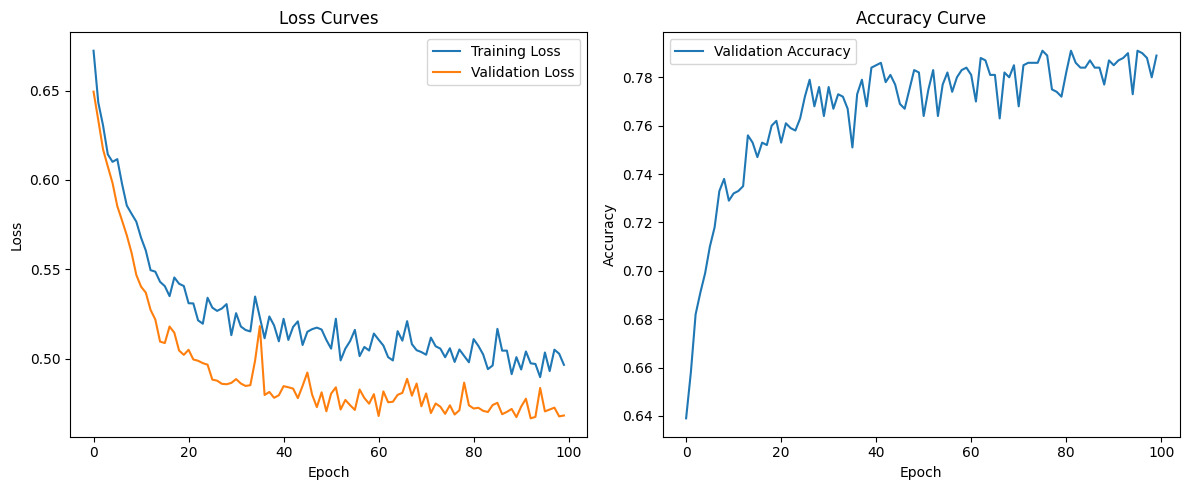

In [ ]:
# Let's modify the Investment Dataset class to handle both Pandas and PyTorch
class InvestmentDatasetFixed(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        # Check if y is already a tensor or needs to be converted
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to get predictions from the enhanced MLP model (i.e., the last estimated one)
def get_predictions_from_mlp(model, X_test):
    # Create a dataset and dataloader for predictions
    dummy_y = pd.Series(np.zeros(len(X_test)))  # Creating a Panda series
    test_dataset = InvestmentDatasetFixed(X_test, dummy_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get predictions
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())

    return np.array(all_preds)

# Filtering accumulation products from our product database
accumulation_products = products_df[products_df['Type'] == 1].copy()
min_risk = accumulation_products['Risk'].min() # Will be used for risk matching later

# # Training the enhanced MLP model for accumulation investment needs prediction
print("\nTraining the enhanced MLP model (Accumulation Investment)")
print("=" * 80)

# Data preparation
X_base, X_engineered = prepare_features(needs_df)
y_accum = needs_df['AccumulationInvestment']
X_train, X_test, y_train, y_test = split_data(X_base, y_accum)

# Create data loaders using our improved Dataset class
train_dataset = InvestmentDatasetFixed(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = InvestmentDatasetFixed(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize and train the model with learning curves visualization
model = MLP(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

# Use the trained model to predict accumulation investment needs for the test set clients
y_pred = get_predictions_from_mlp(model, X_test)



## Client-product matching based on risk profiles

In this section, we implement the core matching algorithm that pairs clients with appropriate investment products. Our approach focuses on risk-appropriate recommendations by matching each client's risk tolerance with suitable product risk levels.

### The matching algorithm explained:

Our recommendation approach follows a simple risk-optimized strategy:

1. **Target client identification**: We focus only on clients who have been predicted to need accumulation investment products by our neural network.

2. **Risk profile analysis**: For each target client, we extract their risk propensity score which indicates the maximum investment risk they can tolerate.

3. **Product filtering**: We identify all accumulation products with risk levels below the client's risk propensity (ensuring suitability from the regulatory point of view).

4. **Optimal selection**: From suitable products, we recommend the one with the highest risk level, maximizing potential returns while respecting risk boundaries.


The scatter plot shows the relationship between client risk propensity and recommended product risk levels. Points below the diagonal line represent conservative recommendations where product risk is lower than the client's risk tolerance.

This risk-optimized approach balances compliance with client protection regulations while seeking to maximize potential investment returns through appropriate risk exposure.

<br>


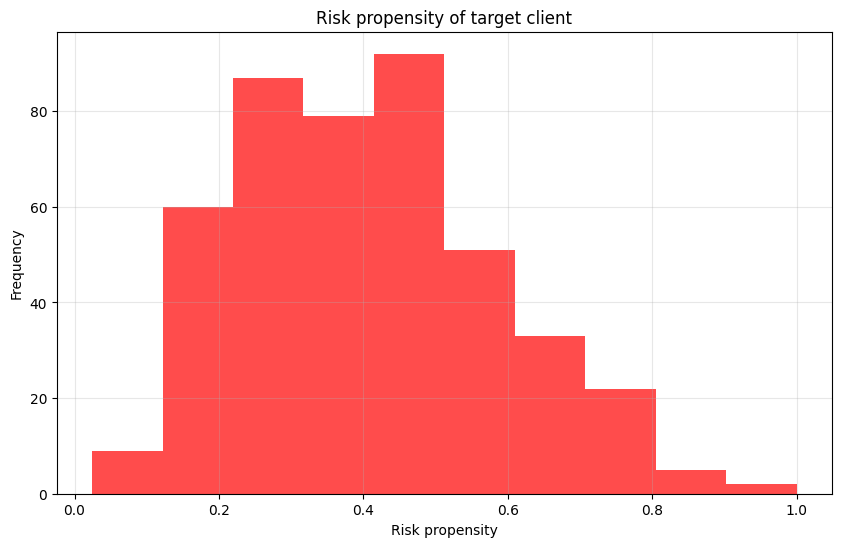


Top 10 personalized recommendations:
   ClientID  RecommendedProductID  ClientRiskPropensity  ProductRiskLevel
0       741                     6              0.363757              0.36
1      4159                     9              0.351479              0.27
2      2352                     1              0.632490              0.55
3      3373                     0              0.185120              0.00
4       827                     8              0.493311              0.48
5      1177                     9              0.326280              0.27
6      1281                     0              0.185263              0.00
7      1506                     8              0.504660              0.48
8      1243                     0              0.231562              0.00
9      1552                     0              0.247239              0.00


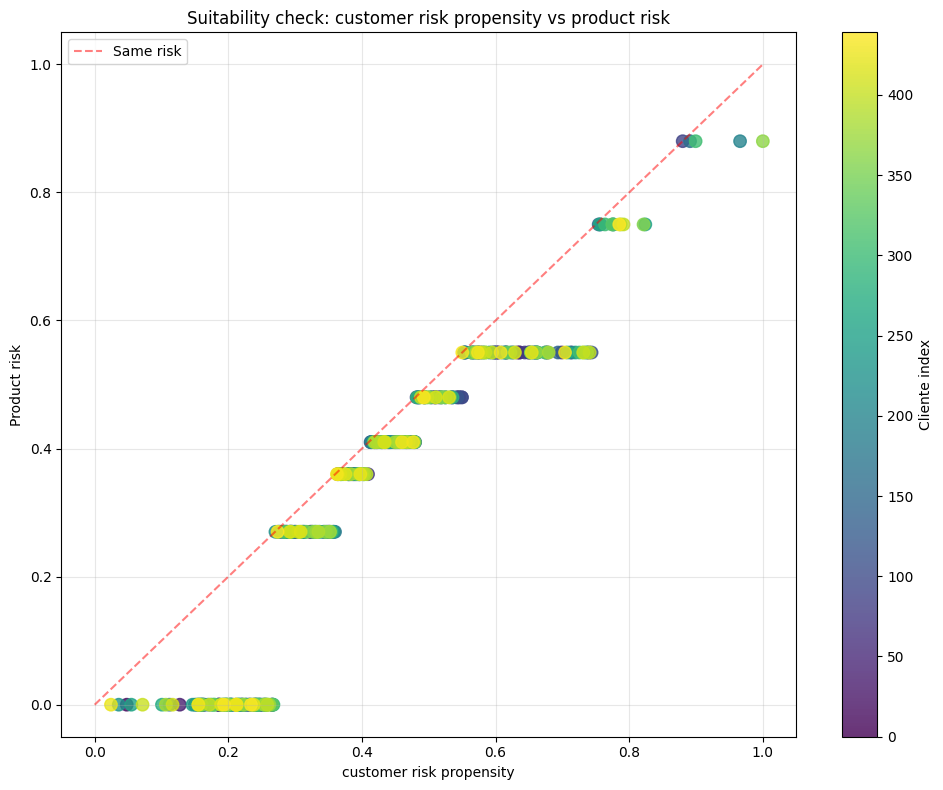

In [ ]:
# Collecting client IDs and their risk propensities from the test set
# We filter for clients predicted to need accumulation products (y_pred == 1)
client_indices = np.where(y_pred == 1)[0]
target_client_ids = needs_df.iloc[X_test.index[client_indices]].index.values
target_client_risk_propensity = X_test.iloc[client_indices]['RiskPropensity'].values

# Visualizing the risk propensity distribution of target clients
plt.figure(figsize=(10, 6))
plt.hist(target_client_risk_propensity, color='r', bins=10, alpha=0.7)
plt.title('Risk propensity of target client')
plt.xlabel('Risk propensity')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Initialize lists to store recommendation results
nba_id_product = []
recommended_risk_level = []

# Extract product information for matching
product_ids = accumulation_products['IDProduct'].astype(np.uint16).values
product_risks = accumulation_products['Risk'].values

# Generate personalized recommendations for each target client
for i in range(len(target_client_risk_propensity)):
    client_risk = target_client_risk_propensity[i]

    if client_risk > min_risk:
        # Find products with acceptable risk (< customer's appetite)
        suitable_products = product_risks[product_risks < client_risk]

        if len(suitable_products) > 0:
            # Find the product with the highest risk among suitable ones
            # This maximizes potential returns while respecting risk tolerance
            max_suitable_risk = max(suitable_products)
            recommended_product_id = product_ids[product_risks == max_suitable_risk][0]
            nba_id_product.append(recommended_product_id)
            recommended_risk_level.append(max_suitable_risk)
        else:
            # No suitable products
            nba_id_product.append(0)
            recommended_risk_level.append(0)
    else:
        #  Client's risk propensity too low for any available product
        nba_id_product.append(0)
        recommended_risk_level.append(0)

# Create a comprehensive recommendation matrix
nba = pd.DataFrame({
    'ClientID': target_client_ids,
    'RecommendedProductID': nba_id_product,
    'ClientRiskPropensity': target_client_risk_propensity,
    'ProductRiskLevel': recommended_risk_level
})

# Display sample recommendations
print("\nTop 10 personalized recommendations:")
print(nba.head(10))

# Suitability Chart: customer risk propensity vs product risk
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    nba['ClientRiskPropensity'],
    nba['ProductRiskLevel'],
    c=range(len(nba)),
    cmap='viridis',
    alpha=0.8,
    s=80
)
plt.colorbar(scatter, label='Cliente index')
plt.title('Suitability check: customer risk propensity vs product risk')
plt.xlabel('customer risk propensity')
plt.ylabel('Product risk')
plt.grid(alpha=0.3)

# Add reference line for perfect risk matching
max_val = max(nba['ClientRiskPropensity'].max(), nba['ProductRiskLevel'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Same risk')
plt.legend()
plt.tight_layout()
plt.show()


## Analyzing recommendation results

In this final section, we analyze the effectiveness and distribution of our personalized product recommendations. Just to understand. We'll examine how many clients received suitable recommendations, which products were most frequently recommended, and the underlying characteristics of those products.

1. **Coverage statistics**: We calculate what percentage of target clients received valid recommendations. Clients without recommendations represent either those with risk tolerance below any available product or those with special needs not met by the current product lineup.

2. **Product distribution**: The bar chart visualizes which products are most frequently recommended across our client base. This helps identify "best-selling" products and potential gaps in the product lineup.

3. **Top product analysis**: For the most frequently recommended products, we provide detailed risk characteristics. This information helps understand which risk levels are most relevant to the current client portfolio.

These analytics provide some insights to product development teams about potential adjustments to the product lineup, such as creating new products to address underserved risk profiles. A data-driven approach helps to understanding both the effectiveness of the recommendation system and the alignment between the client base and product offerings.

<br>


Recommendation statistics:
Total customers analyzed: 440
Customers with valid recommendations: 326 (74.09%)
Customers without suitable recommendations: 114


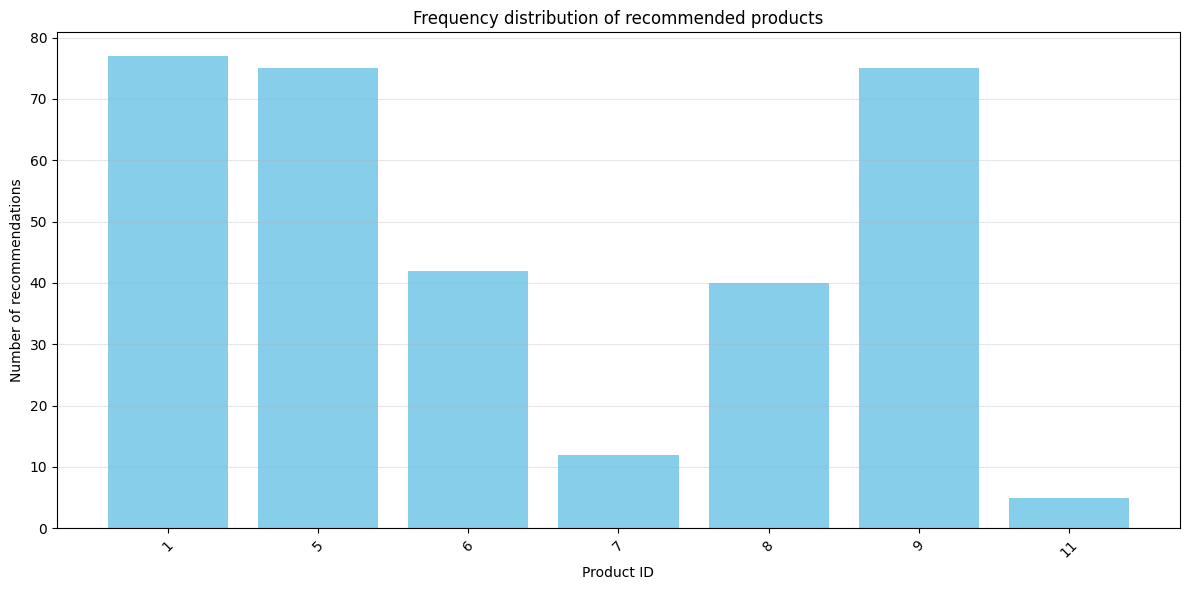


Details on the most recommended products:

Product ID: 1
Risk: 0.55
Recommended to 77 clients

Product ID: 5
Risk: 0.41
Recommended to 75 clients

Product ID: 9
Risk: 0.27
Recommended to 75 clients


In [ ]:
# Analysis of recommendations
total_clients = len(nba)
clients_with_recommendations = len(nba[nba['RecommendedProductID'] > 0])
percentage_with_recommendations = (clients_with_recommendations / total_clients) * 100

print(f"\nRecommendation statistics:")
print(f"Total customers analyzed: {total_clients}")
print(f"Customers with valid recommendations: {clients_with_recommendations} ({percentage_with_recommendations:.2f}%)")
print(f"Customers without suitable recommendations: {total_clients - clients_with_recommendations}")

# Frequency distribution of recommended products
if clients_with_recommendations > 0:
    plt.figure(figsize=(12, 6))

    # Recommended products
    recommendation_counts = nba['RecommendedProductID'].value_counts().sort_index()
    recommendation_counts = recommendation_counts[recommendation_counts.index > 0]  # Escludi ID 0

    plt.bar(recommendation_counts.index.astype(str), recommendation_counts.values, color='skyblue')
    plt.title('Frequency distribution of recommended products')
    plt.xlabel('Product ID')
    plt.ylabel('Number of recommendations')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Details on the most recommended products
    if len(recommendation_counts) > 0:
        top_products = recommendation_counts.nlargest(3).index
        print("\nDetails on the most recommended products:")
        for prod_id in top_products:
            product_details = accumulation_products[accumulation_products['IDProduct'] == prod_id]
            print(f"\nProduct ID: {prod_id}")
            print(f"Risk: {product_details['Risk'].values[0]}")
            print(f"Recommended to {recommendation_counts[prod_id]} clients")
else:
    print("\nNo products were recommended to the analyzed customers")



# **HINTs**

### **Try different algorithms**
* **Try different models, such as Random Forest**, or other classifiers.
* **Try a single multi-output classifier** instead of multiple binary classifiers. Don't forget simple models like **KNN** - it is not uncommon for them to perform better than much more complex models.

### **Try to optimize the algorithms**
* For example, **try various configurations of the NN**, to gain sensitivity and experience: for example try to narrow and widen the size of the NN, with various geometries (e.g. more or less "narrow" in the center), change the activatiuon function, and so on. Just to understand the consequences.

### **Implement a voting classifier (soft voting or/and hard voting)**
A **voting classifier** is an ensemble method that **combines multiple classifiers** to improve predictive performance.  It operates using two main mechanisms:  
* **Hard voting**: Each model **casts a vote** for a class, and the final prediction is the **majority vote** (i.e., the most frequently predicted class).  
* **Soft voting**: Instead of discrete votes, models **output probabilities**, and the final prediction is based on the **weighted average of probabilities**, favoring higher-confidence predictions.  

💡 **Voting classifiers are very useful: they are robust, improving stability and accuracy**, especially when combining **diverse models with complementary strengths and weaknesses**. You can use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html). As a reference, see for example [this short post](https://www.kaggle.com/code/marcinrutecki/voting-classifier-for-better-results).

If you think about it, you can also use the **Bayesian Beta Binomial model that I briefly introduced last time**: the output of the classifier is a number between 0 and 1...

In case it wasn't clear already: I strongly encourage you to use voting classifiers, and, in general, model averaging.

### **Implement a stacking classifier**
It's just one step beyond the voting classifier: **Stacking, or Stacked Generalization** is an **ensemble learning technique** where multiple models are combined, but instead of simple voting, their outputs are **weighted through a learning process**. So, unlike voting, stacking doesn’t just aggregate predictions — there is a model that actively learns how to combine them optimally.


**How it Works:**  
    1. **Train multiple base models** (e.g., KNN, SVMs, NN) on the same dataset.  
    2. **Collect their predictions** and use them as input features for a **meta-model** (often a linear regression, logistic regression, or another ML model, typically not too complex, otherwise it's a mess...).  
    3. The **meta-model learns optimal weights** for combining base model predictions, hopefully improving overall performance.  


You can use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier). If you are using Pytorch, you can use [Ensemble PyTorch](https://ensemble-pytorch.readthedocs.io/en/latest/), or, if you need scikit-learn, you can use [Skorch](https://github.com/skorch-dev/skorch), a scikit-learn compatible neural network library that wraps PyTorch: so you can use scikit-learn and Pytorch together.

Stacking application tends to require more data. But it makes sense to try.

### **AutoML**
Consider **automated hyperparameter optimization** using **AutoML tools** like:
* [Optuna](https://optuna.readthedocs.io/en/stable/index.html#).
* [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).
* [Keras Tuner](https://keras.io/keras_tuner).
* ...and many others.

My 2 Cents:

AutoML tools can significantly improve model performance by:
- Systematically exploring the hyperparameter space, which is very large.
- Running parallel experiments.
- Tracking and comparing results,
- Implementing advanced search strategies like Bayesian Optimization.

<br>

For the bravest...

## **Recommender Systems using SVD and Autoencoders**
Everyting starts from the **user-item interaction matrix**: a structured representation of user-product engagement, where rows represent users, columns represent items (like products or movies), and each cell contains a binary (0/1) or numeric value indicating whether a user has interacted with an item (e.g., purchased, viewed, rated). Essentially, it's a data table that captures the relationship between users and items, serving as the fundamental input for recommendation algorithms.

A couple of relatively popular methods are SVD and Autoencoders, both aimed to find **latent factors** underlying the relationship between users and products.

### **Singular Value Decomposition (SVD)**
**Core Idea**: decompose user-item interaction matrix into linear components representing latent factors.
- Mathematical factorization of sparse interaction matrix.
- Assumes linear relationships between users, items, and preferences.
- Efficient for small to medium datasets.
- Identifies primary orthogonal dimensions explaining user behavior.
- Computationally lightweight.

### **Autoencoder**
**Core Idea**: learning complex, non-linear representations of user-item interactions through Neural Networks. A non-linear version of SVD.
- Compress high-dimensional interaction data into dense, meaningful latent space.
- Capture sophisticated, non-linear patterns in user preferences.
- Adaptable to complex, large-scale datasets.
- Automatically learns feature representations.
- More flexible in modeling intricate recommendation dynamics.


**Choose Based On**:
- Dataset complexity.
- Computational resources and data availability.
- Desired recommendation sophistication.

<br>